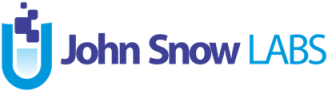

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/misc/HF_Callback_Text_Classification.ipynb)

**LangTest** is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, Spacy** models or **OpenAI, Cohere, AI21, Hugging Face Inference API and Azure-OpenAI** based LLMs, it has got you covered. You can test any Named Entity Recognition (NER), Text Classification, fill-mask, Translation model using the library. We also support testing LLMS for Question-Answering, Summarization and text-generation tasks on benchmark datasets. The library supports 60+ out of the box tests. For a complete list of supported test categories, please refer to the [documentation](http://langtest.org/docs/pages/docs/test_categories).

Metrics are calculated by comparing the model's extractions in the original list of sentences against the extractions carried out in the noisy list of sentences. The original annotated labels are not used at any point, we are simply comparing the model against itself in a 2 settings.

# Getting started with LangTest

In [ ]:
!pip install langtest[transformers]

# LangTestCallback and Its Parameters

The LangTestCallback class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a NLP model on a given task using test data and generates a report with test results. It can be imported from the LangTest library in the following way.

In [1]:
#Import Harness from the LangTest library
from langtest.callback import LangTestCallback

It imports the callback class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and instances of the callback class can be customized or configured for different testing scenarios or environments then provided to the trainer.

Here is a list of the different parameters that can be passed to the LangTestCallback function:

<br/>

| Parameter             | Description |
| --------------------- | ----------- |
| **task**              | Task for which the model is to be evaluated (text-classification or ner) |
| **data**              | The data to be used for evaluation. A dictionary providing flexibility and options for data sources. It should include the following keys: <ul><li>data_source (mandatory): The source of the data.</li><li>subset (optional): The subset of the data.</li><li>feature_column (optional): The column containing the features.</li><li>target_column (optional): The column containing the target labels.</li><li>split (optional): The data split to be used.</li><li>source (optional): Set to 'huggingface' when loading Hugging Face dataset.</li></ul> |
| **config**            | Configuration for the tests to be performed, specified in the form of a YAML file. |
| **print_reports**     | A bool value that specifies if the reports should be printed. |
| **save_reports**      | A bool value that specifies if the reports should be saved. |
| **run_each_epoch**    | A bool value that specifies if the tests should be run after each epoch or the at the end of training |

<br/>
<br/>

In [ ]:
!pip install datasets
!pip install transformers[torch]
!pip install tensorflow -U

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import torch

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# Model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# model to device

dataset = load_dataset("imdb")
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
train_dataset = dataset["train"].select(range(25)).map(tokenize, batched=True)

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

## Creating a LangTestCallback Instance

After loading the model and tokenizer from huggingface, we can get to the training part of our process. We will utilize `transformers.Trainer` for easily integrating our callback into the training process. We will also use `transformers.TrainingArguments` to specify the training arguments.

We can store the config in a dictionary and pass it to the LangTestCallback function for easier use and visual appeal. The config will be used in this notebook is below:

In [4]:
config = {
 "tests": {
  "defaults": {
   "min_pass_rate": 1.0
  },
  "robustness": {
   "add_typo": {"min_pass_rate": 0.7},
   "uppercase": {"min_pass_rate": 0.7},
   "american_to_british": {"min_pass_rate": 0.7},
  },
  "accuracy": {
   "min_micro_f1_score": {
    "min_score": 0.7
   }
  },
  "bias": {
   "replace_to_female_pronouns": {
    "min_pass_rate": 0.7
   },
   "replace_to_low_income_country": {
    "min_pass_rate": 0.7
   }
  }
 }
}

In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/langtest/main/langtest/data/imdb/sample.csv

In [5]:
my_callback = LangTestCallback(task="text-classification", data={"data_source":"sample.csv"}, config=config, save_reports=True, run_each_epoch=True)

## Creating the Trainer

As mentioned earlier, we create a TrainingArguments object to specify the training arguments. We will also create a Trainer object to train our model. Then we can pass the LangTestCallback object to the Trainer object as a callback. LangTestCallback initilizes the harness object and generates the testcases using .generate() after the trainer is initialized.

In [6]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    callbacks=[my_callback]
)

Test Configuration : 
 {
 "tests": {
  "defaults": {
   "min_pass_rate": 1.0
  },
  "robustness": {
   "add_typo": {
    "min_pass_rate": 0.7
   },
   "uppercase": {
    "min_pass_rate": 0.7
   },
   "american_to_british": {
    "min_pass_rate": 0.7
   }
  },
  "accuracy": {
   "min_micro_f1_score": {
    "min_score": 0.7
   }
  },
  "bias": {
   "replace_to_female_pronouns": {
    "min_pass_rate": 0.7
   },
   "replace_to_low_income_country": {
    "min_pass_rate": 0.7
   }
  }
 }
}


## Training

The actual training step is very simple. We just need to call the train() method of the Trainer object. We can also pass the training arguments to the train() method but its default values are OK in this case.

Below, we have the reports printed and also saved under the reports folder. The reports are saved in the form of a MD file. The reports folder is created in the same directory as the notebook.

In [7]:
# Training the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2649: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(
Generating testcases...: 100%|██████████| 3/3 [00:00<00:00, 15768.06it/s]
[W010] - Test 'add_typo': 11 samples removed out of 200
[W010] - Test 'american_to_british': 138 samples removed out of 200

[W010] 

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,add_typo,0,189,100%,70%,True
1,robustness,uppercase,0,200,100%,70%,True
2,robustness,american_to_british,0,62,100%,70%,True
3,accuracy,min_micro_f1_score,1,0,0%,100%,False
4,bias,replace_to_female_pronouns,0,171,100%,70%,True
5,bias,replace_to_low_income_country,0,28,100%,70%,True


Running testcases... :   0%|          | 0/651 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2649: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(
Running testcases... : 100%|██████████| 651/651 [00:21<00:00, 30.08it/s]


,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,add_typo,0,189,100%,70%,True
1,robustness,uppercase,0,200,100%,70%,True
2,robustness,american_to_british,0,62,100%,70%,True
3,accuracy,min_micro_f1_score,1,0,0%,100%,False
4,bias,replace_to_female_pronouns,0,171,100%,70%,True
5,bias,replace_to_low_income_country,0,28,100%,70%,True


Running testcases... :   0%|          | 0/651 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2649: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(
Running testcases... : 100%|██████████| 651/651 [00:20<00:00, 31.25it/s]


,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,add_typo,0,189,100%,70%,True
1,robustness,uppercase,0,200,100%,70%,True
2,robustness,american_to_british,0,62,100%,70%,True
3,accuracy,min_micro_f1_score,1,0,0%,100%,False
4,bias,replace_to_female_pronouns,0,171,100%,70%,True
5,bias,replace_to_low_income_country,0,28,100%,70%,True


{'train_runtime': 281.2316, 'train_samples_per_second': 0.267, 'train_steps_per_second': 0.043, 'train_loss': 0.14822853604952493, 'epoch': 3.0}


TrainOutput(global_step=12, training_loss=0.14822853604952493, metrics={'train_runtime': 281.2316, 'train_samples_per_second': 0.267, 'train_steps_per_second': 0.043, 'train_loss': 0.14822853604952493, 'epoch': 3.0})